# Library

In [109]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import average_precision_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import pickle
from sklearn.model_selection import cross_val_score, KFold
from bertopic import BERTopic
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

# LightGBM

In [2]:
df = pd.read_parquet('../ResultsBERTopic/BERTopic_nodefinedcluster_topics_15n_10com_1200cluster_0.64sil_renewout.parquet')
df.head()

,Document,Embedding,Topic,Probability,Created_on,Count,Name,Representation,Representative_Docs,UMAP_embedding
0,checks,"[0.052164897, 0.029597273, -0.03666609, 0.0051...",4,0.000000,2020-01-09,6299,4_mdma_lsd_get_looking,"[mdma, lsd, get, looking, wsm, good, btc, ques...","[hey ro im gon na pull pk, life wonderful life...","[1.6488198, 9.914265, 1.442794, 2.8094368, -0...."
1,trusted vendor status,"[0.02445144, -0.008732641, -0.0050215074, 0.01...",2,0.944247,2020-01-09,6907,2_vendor_scammer_scam_looking,"[vendor, scammer, scam, looking, scamming, sal...","[looking good reliable vendor sell ounce, vend...","[2.910516, 10.281041, 1.650234, 3.0320778, -0...."
2,empire exit scam iiflux user incomming,"[0.02890829, 0.036081452, -0.027694924, -0.007...",1,1.000000,2019-11-06,6236,1_market_empire_dream_nightmare,"[market, empire, dream, nightmare, vendor, dre...","[next market, dream market vendor rstclass nig...","[1.5884036, 9.8587885, 3.3090453, 2.652358, 2...."
3,ecstasy vendor packs,"[-0.022524439, 0.03949761, -0.023750877, 0.033...",5,0.797741,2020-01-09,2776,5_order_package_shipping_delivery,"[order, package, shipping, delivery, pack, shi...",[order accepted day still hasnt marked shipped...,"[2.0245404, 10.517631, 2.3443217, 3.7595236, -..."
4,opening bank account person fake id,"[-0.029834118, 0.03354508, -0.012210185, -0.02...",6,1.000000,2019-11-06,2823,6_bitcoin_card_wallet_btc,"[bitcoin, card, wallet, btc, bank, credit, car...","[credit cards paypal prepaid card find, got cc...","[0.7278271, 9.884823, 1.8116106, 2.9336705, -0..."


In [3]:
df = df[['Topic', 'Embedding']]
df['Topic'] = df['Topic'].astype(int)

In [4]:
embedding_dim = len(df['Embedding'][0])
embedding_cols = pd.DataFrame(df['Embedding'].tolist(), index=df.index, columns=[f'embedding_{i}' for i in range(embedding_dim)])
df = pd.concat([df, embedding_cols], axis=1)

In [28]:
X = df.drop(columns=['Topic', 'Embedding'])
y = df["Topic"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

In [29]:
X_train.shape, X_valid.shape, X_test.shape

((26541, 512), (5687, 512), (5688, 512))

## Training

In [30]:
params = {
    'objective': 'multiclass',
    'num_class': len(y.unique()),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 20,
    'max_depth': 8,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'verbose': 1
}

eval_result = {}
bst = lgb.train(params,
                train_data,
                valid_sets=[train_data, valid_data],
                num_boost_round=1000,
                callbacks=[
                    lgb.early_stopping(stopping_rounds=3),
                    lgb.log_evaluation(period=10),
                    lgb.record_evaluation(eval_result)
                ])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 26541, number of used features: 512
[LightGBM] [Info] Start training from score -1.498835
[LightGBM] [Info] Start training from score -1.787811
[LightGBM] [Info] Start training from score -1.699300
[LightGBM] [Info] Start training from score -2.197903
[LightGBM] [Info] Start training from score -1.792325
[LightGBM] [Info] Start training from score -2.594080
[LightGBM] [Info] Start training from score -2.601673
Training until validation scores don't improve for 3 rounds
[10]	training's multi_logloss: 0.546982	valid_1's multi_logloss: 0.586566
[20]	training's multi_logloss: 0.274753	valid_1's multi_logloss: 0.331047
[30]	training's multi_logloss: 0.167201	valid_1's multi_logloss: 0.236761
[40]	training's multi_logloss: 0.110387	valid_1'

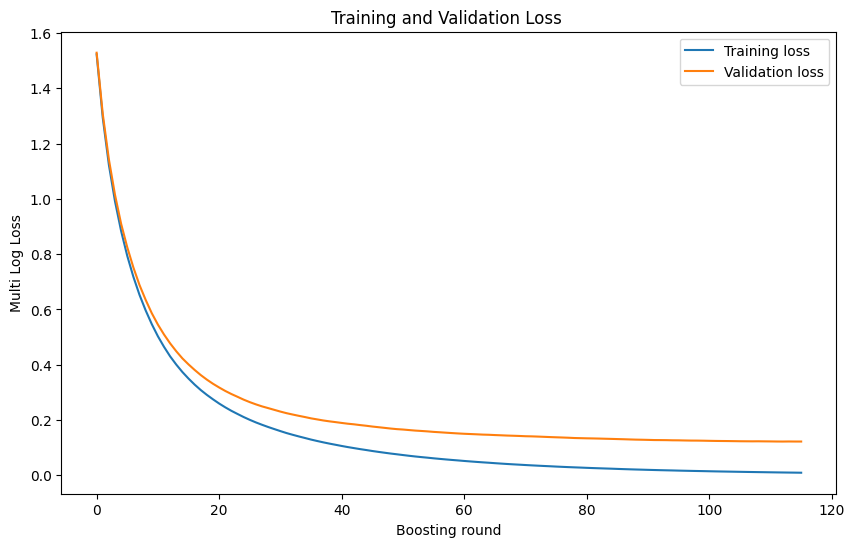

In [34]:
def plot_loss(eval_result, title=""):
    """
    Plot the training and validation loss
    :param eval_result: The evaluation results
    """
    train_losses = eval_result['training']['multi_logloss']
    valid_losses = eval_result['valid_1']['multi_logloss']
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.xlabel('Boosting round')
    plt.ylabel('Multi Log Loss')
    plt.title(f'Training and Validation Loss {title}')
    plt.legend();

plot_loss(eval_result)

## Evaluation

In [31]:
y_pred = bst.predict(X_test)
y_pred_max = [np.argmax(line) for line in y_pred]
print(f"Classification Report on Test Set:\n\n{classification_report(y_test, y_pred_max)}")

Classification Report on Test Set:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1398
           1       0.96      0.96      0.96       871
           2       0.95      0.94      0.94      1005
           3       0.98      0.98      0.98       619
           4       0.95      0.97      0.96       953
           5       0.94      0.93      0.94       407
           6       0.97      0.94      0.95       435

    accuracy                           0.96      5688
   macro avg       0.96      0.96      0.96      5688
weighted avg       0.96      0.96      0.96      5688



In [32]:
y_pred = bst.predict(X_valid)
y_pred_max_valid = [np.argmax(line) for line in y_pred]
print(f"Classification Report on Validation Set:\n\n{classification_report(y_valid, y_pred_max_valid)}")

Classification Report on Validation Set:

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1318
           1       0.97      0.96      0.97       924
           2       0.95      0.96      0.96      1050
           3       0.98      0.97      0.98       664
           4       0.95      0.96      0.95       925
           5       0.95      0.91      0.93       386
           6       0.95      0.95      0.95       420

    accuracy                           0.96      5687
   macro avg       0.96      0.95      0.96      5687
weighted avg       0.96      0.96      0.96      5687



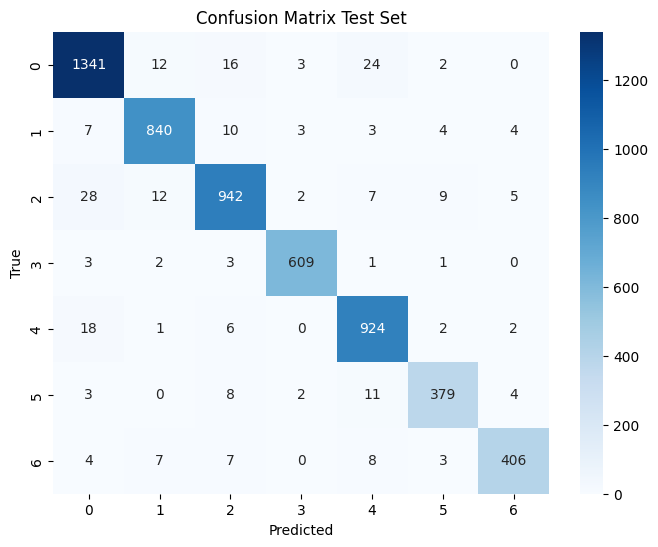

In [80]:
cm = confusion_matrix(y_test, y_pred_max)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Test Set')
plt.show()

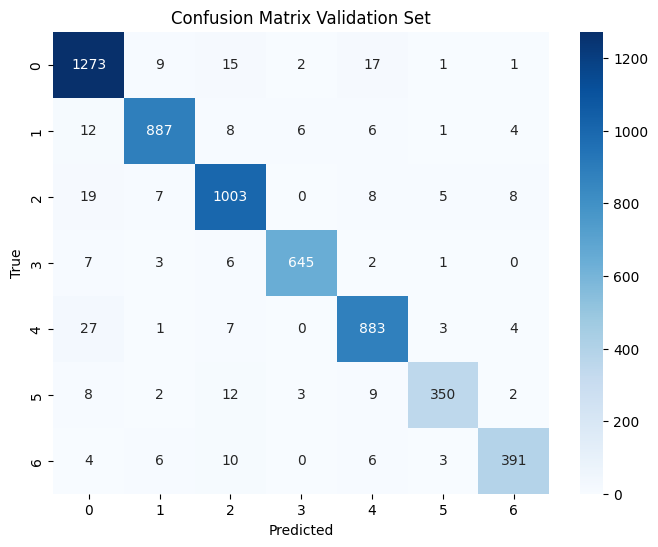

In [81]:
cm = confusion_matrix(y_valid, y_pred_max_valid)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Validation Set')
plt.show()

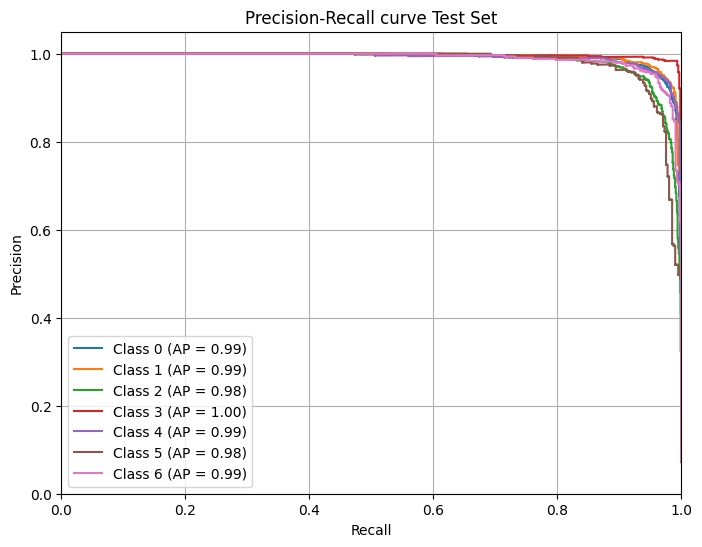

In [82]:
classes = np.unique(y)
y_test_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
y_test_bin = label_binarize(y_test, classes=classes)

precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_test_pred[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_test_pred[:, i])

plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.step(recall[i], precision[i], where='post', label=f'Class {classes[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve Test Set')
plt.legend(loc='best')
plt.grid(True)
plt.show()

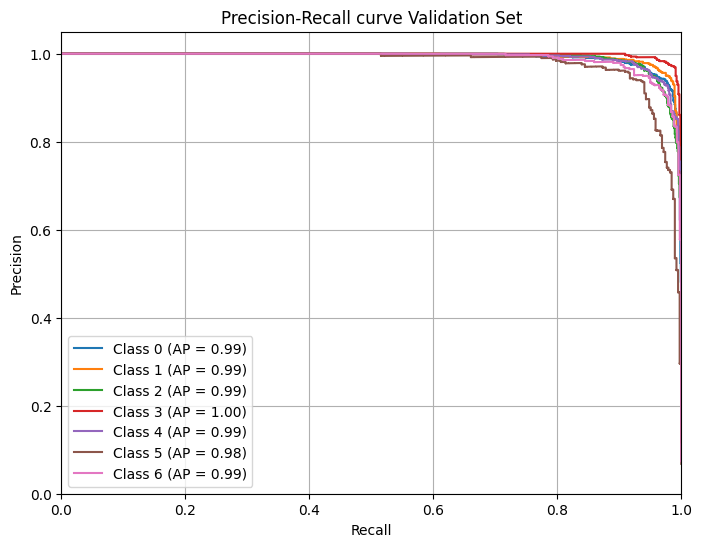

In [83]:
classes = np.unique(y)
y_valid_pred = bst.predict(X_valid, num_iteration=bst.best_iteration)
y_valid_bin = label_binarize(y_valid, classes=classes)

precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_valid_bin[:, i], y_valid_pred[:, i])
    average_precision[i] = average_precision_score(y_valid_bin[:, i], y_valid_pred[:, i])

plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.step(recall[i], precision[i], where='post', label=f'Class {classes[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve Validation Set')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Save Model

In [70]:
with open('model.pkl', 'wb') as f:
    pickle.dump(bst, f)

In [71]:
bst.save_model('model.txt')

## Validate Results: K-Fold Cross Validation

In [43]:
def k_fold(n_splits=5):
    """
    Perform k-fold cross-validation on the training set.
    :param n_splits: number of splits
    :return: classification report for each fold
    """
    params = {
        'objective': 'multiclass',
        'num_class': len(y.unique()),
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': 0.1,
        'num_leaves': 20,
        'max_depth': 8,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.6,
        'bagging_freq': 5,
        'verbose': 0
    }

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    class_accuracies = {i: [] for i in range(len(y.unique()))}

    fold = 1

    # Loop through the folds
    for train_index, valid_index in kf.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

        eval_result = {}

        # Train the model
        bst_fold = lgb.train(params,
                        train_data,
                        valid_sets=[train_data, valid_data],
                        num_boost_round=1000,
                        callbacks=[
                            lgb.early_stopping(stopping_rounds=3),
                            lgb.record_evaluation(eval_result)
                        ])

        # Predictions on the validation set
        y_valid_pred = np.argmax(bst_fold.predict(X_valid), axis=1)

        # Calculate classification report
        report = classification_report(y_valid, y_valid_pred, output_dict=True)

        # Extract per-class accuracy (recall)
        for class_id in class_accuracies.keys():
            class_accuracies[class_id].append(report[str(class_id)]['recall'])

        plot_loss(eval_result, title=f"Fold {fold}")

        fold += 1

    return class_accuracies

def summarize_k_fold(class_accuracies):
    """
    Summarize the results of the k-fold cross-validation
    :param class_accuracies: the results of the k-fold cross-validation
    :return: a DataFrame with the mean and standard deviation of the per-class accuracies
    """
    class_accuracies = pd.DataFrame(class_accuracies)
    class_accuracies['mean'] = class_accuracies.mean(axis=1)
    class_accuracies['std'] = class_accuracies.std(axis=1)
    return class_accuracies

### 5 Folds

Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[155]	training's multi_logloss: 0.00408097	valid_1's multi_logloss: 0.123216
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.00939282	valid_1's multi_logloss: 0.125089
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[136]	training's multi_logloss: 0.00694747	valid_1's multi_logloss: 0.117786
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[137]	training's multi_logloss: 0.00682063	valid_1's multi_logloss: 0.116092
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[153]	training's multi_logloss: 0.004463	valid_1's multi_logloss: 0.121625


,0,1,2,3,4,5,6,mean,std
0,0.963829,0.961538,0.948424,0.976852,0.965517,0.917308,0.934397,0.952552,0.019106
1,0.959149,0.966828,0.946349,0.978443,0.963521,0.917710,0.936057,0.952580,0.019133
2,0.974883,0.969460,0.951015,0.963235,0.961851,0.928693,0.939394,0.955504,0.015441
3,0.962963,0.961568,0.949358,0.971564,0.976190,0.933333,0.951220,0.958028,0.013530
4,0.969346,0.947798,0.958146,0.983927,0.967383,0.927817,0.949495,0.957702,0.016801


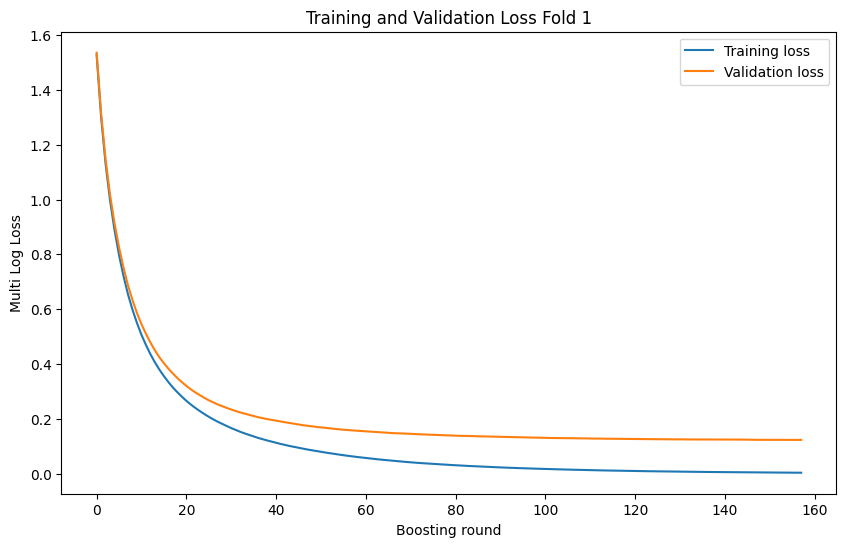

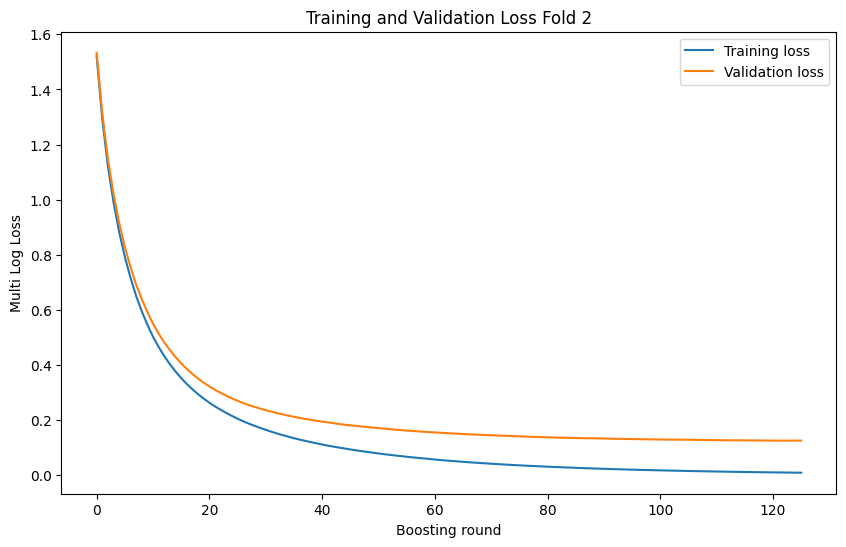

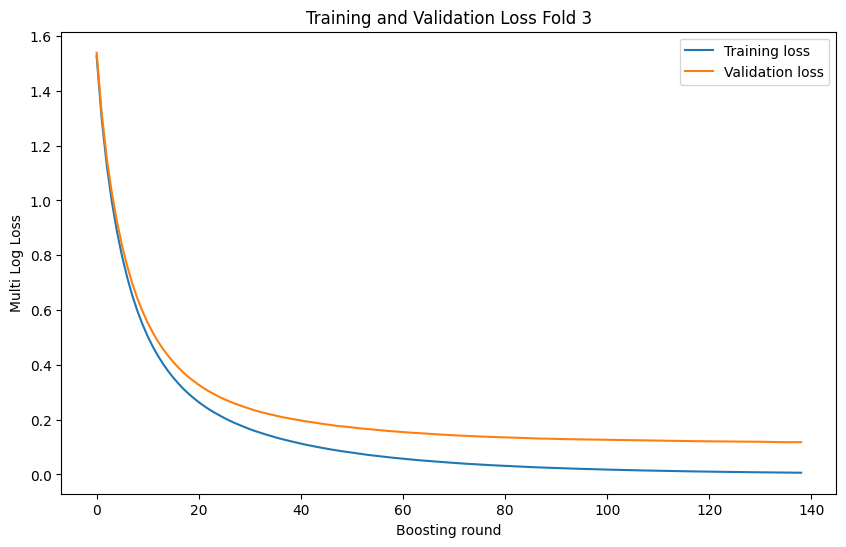

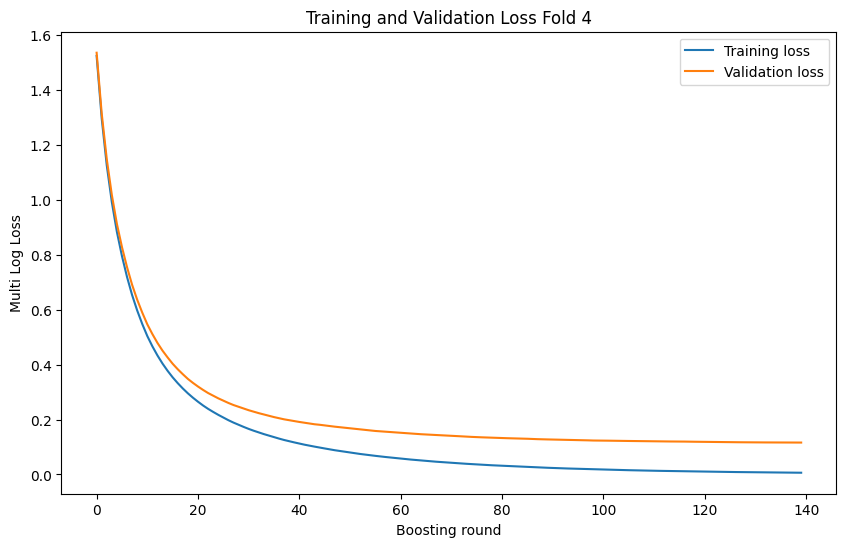

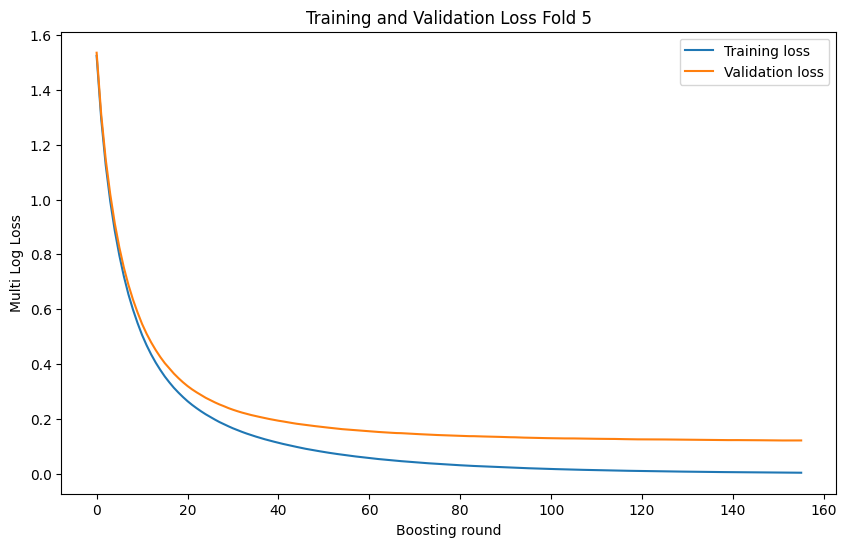

In [44]:
summarize_k_fold(k_fold(n_splits=5))

### 10 Folds

Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[124]	training's multi_logloss: 0.0111886	valid_1's multi_logloss: 0.130837
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[138]	training's multi_logloss: 0.00783173	valid_1's multi_logloss: 0.118419
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[124]	training's multi_logloss: 0.011342	valid_1's multi_logloss: 0.119824
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.0107347	valid_1's multi_logloss: 0.127123
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[128]	training's multi_logloss: 0.0101108	valid_1's multi_logloss: 0.131797
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[143]	training's multi_logloss: 0.00712036	valid_1

,0,1,2,3,4,5,6,mean,std
0,0.963616,0.960208,0.941261,0.972973,0.959283,0.923077,0.955326,0.953678,0.015299
1,0.967416,0.966019,0.954155,0.978571,0.969984,0.911538,0.941392,0.955582,0.021139
2,0.961915,0.963272,0.946970,0.978520,0.963550,0.937729,0.955326,0.958183,0.012157
3,0.967742,0.971743,0.950147,0.976019,0.968254,0.902098,0.933824,0.952832,0.024779
4,0.971698,0.963550,0.949650,0.958810,0.958472,0.912458,0.931298,0.949419,0.019126
5,0.969942,0.965997,0.955182,0.973545,0.976190,0.921233,0.962406,0.960642,0.017359
6,0.961588,0.974006,0.946704,0.969626,0.972686,0.923372,0.949153,0.956733,0.016961
7,0.959427,0.955108,0.956459,0.973558,0.970497,0.921147,0.935484,0.953097,0.017353
8,0.968370,0.942948,0.952518,0.983796,0.959481,0.915254,0.956522,0.954127,0.019843
9,0.966924,0.952941,0.956454,0.984055,0.967136,0.926740,0.935593,0.955692,0.018173


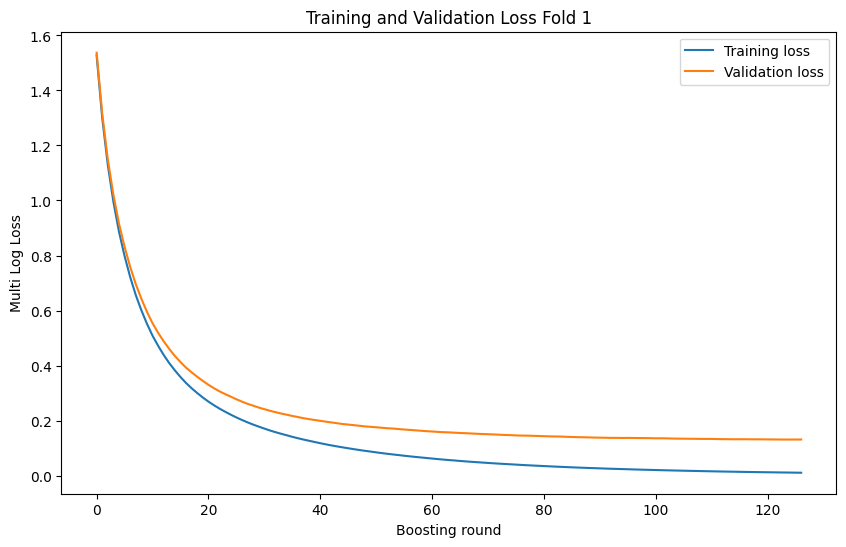

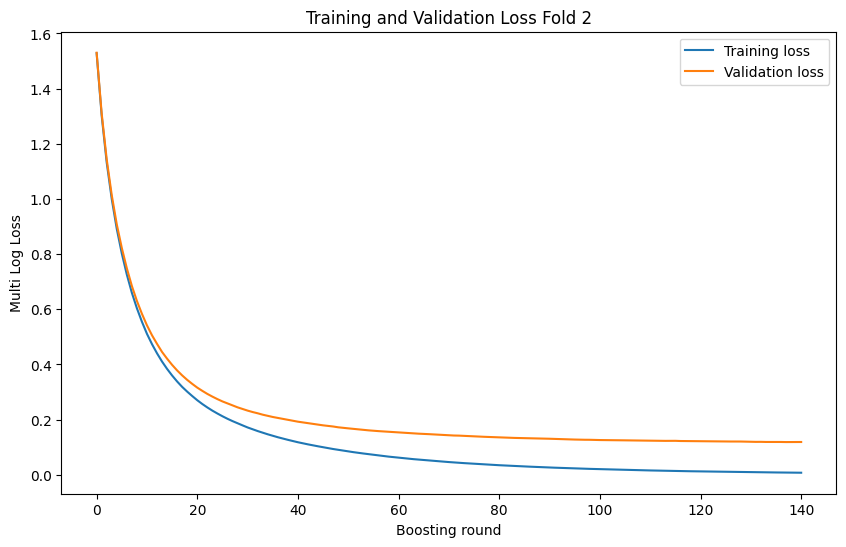

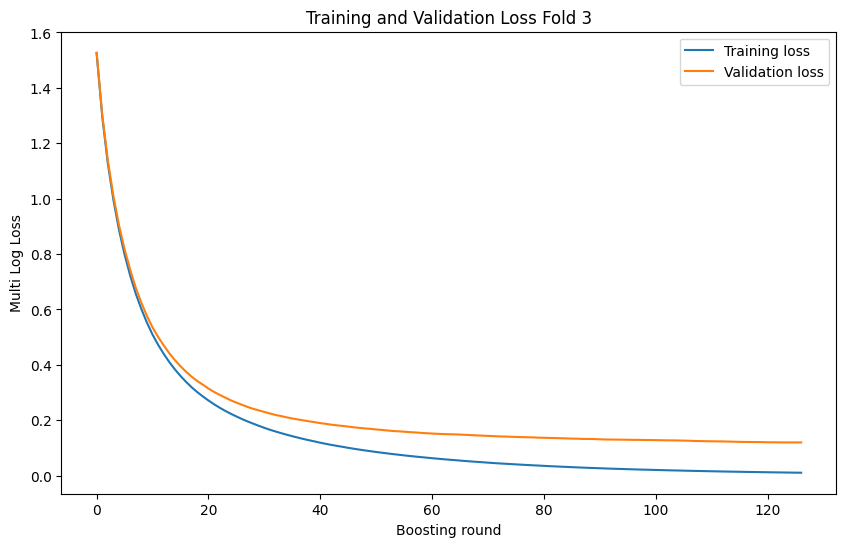

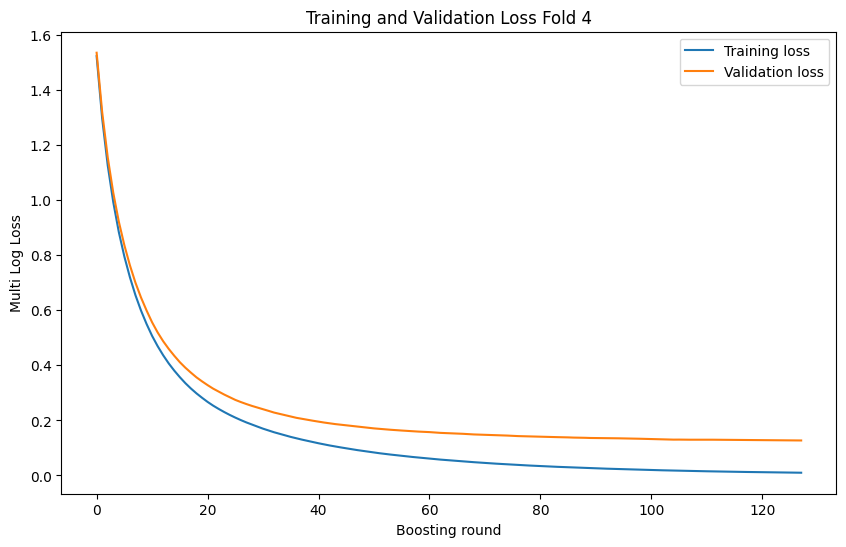

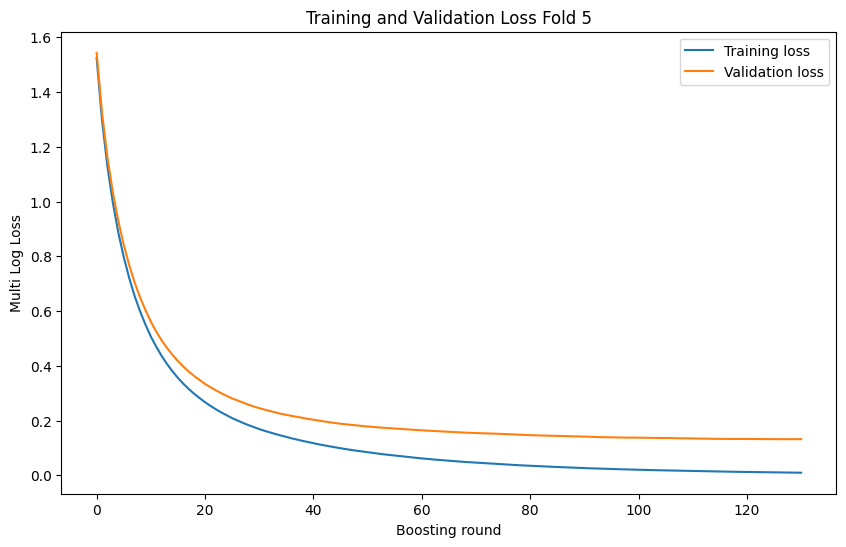

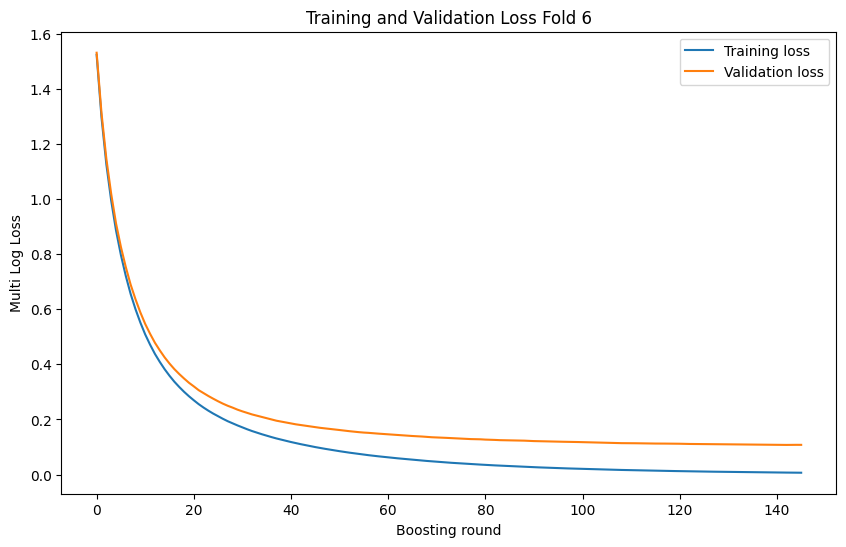

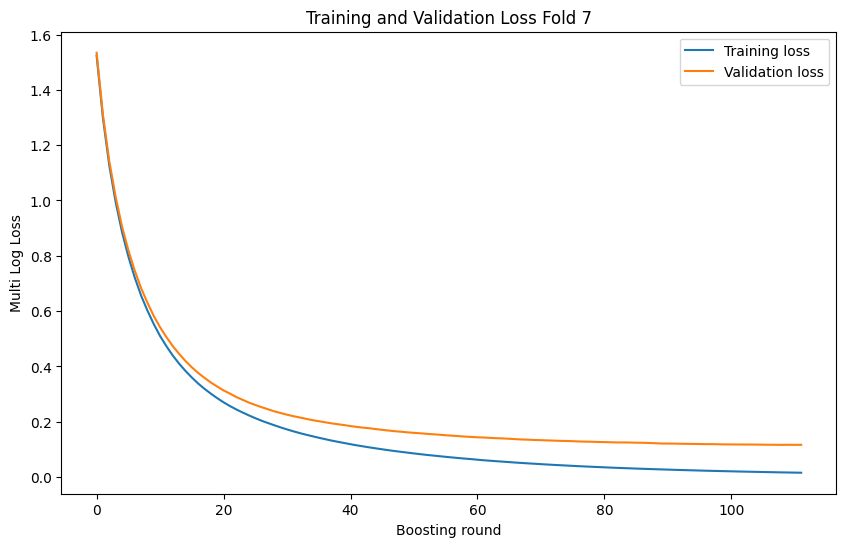

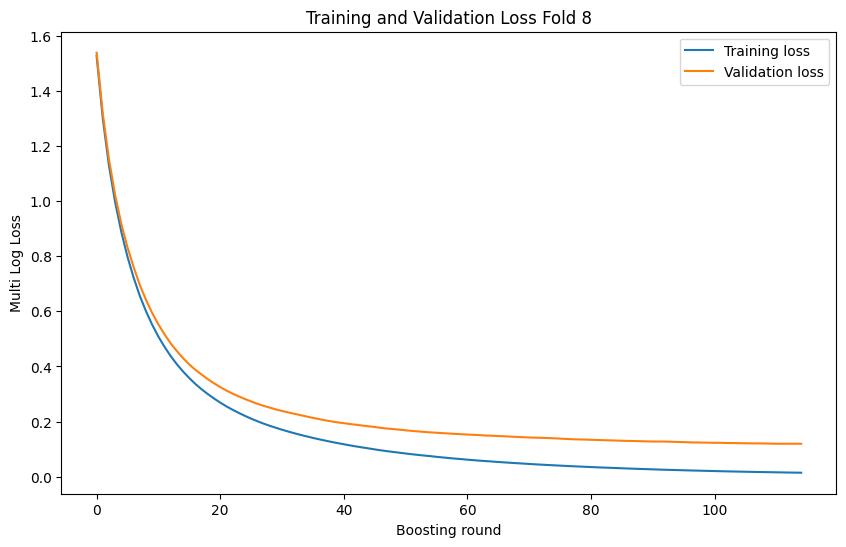

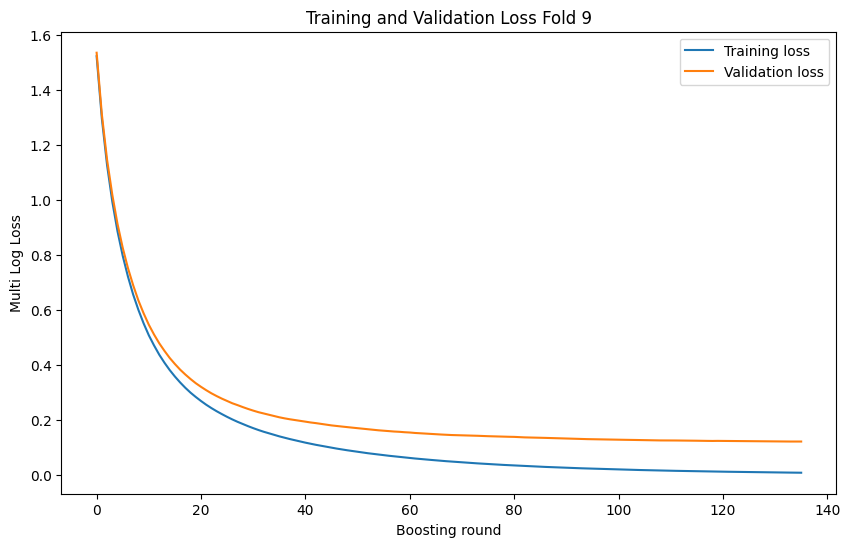

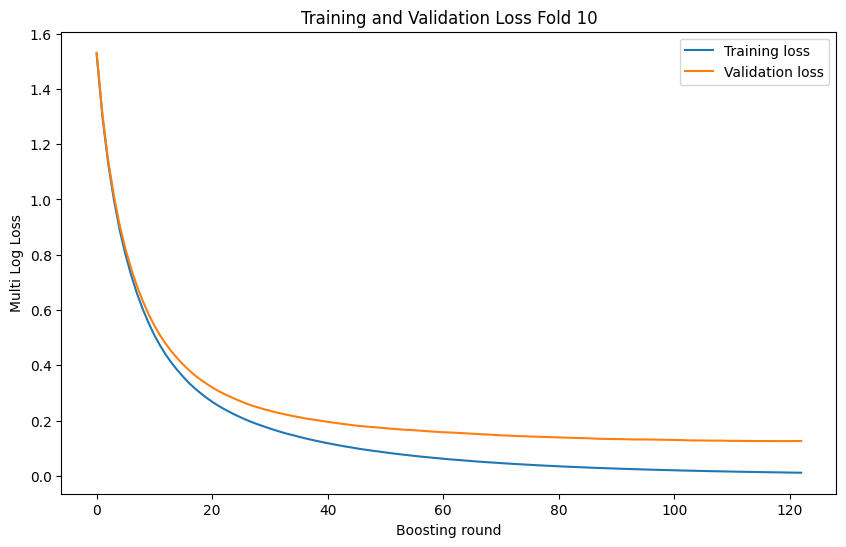

In [45]:
summarize_k_fold(k_fold(n_splits=10))

## Predict Example

In [102]:
sentence_transformer = SentenceTransformer('distiluse-base-multilingual-cased-v1')
bert_model = BERTopic.load('../Models/topic_model_0.64SilNew')
lgb_model = pickle.load(open('model.pkl', 'rb'))

In [107]:
sentence = ['Sell account, passwords, and other illegal stuff.']
sentence_embedding = sentence_transformer.encode(sentence)
topic, _ = bert_model.transform(sentence, embeddings=sentence_embedding)
topic

[-1]

In [108]:
np.argmax(lgb_model.predict(sentence_embedding))

2